# Visualisation of the uncertainty in the baseline scenario
Script to visualise the uncertainty for the baseline results. Figure 4 of the NHESS paper.

In [1]:
import sys
sys.path.append("..") #import folder which is one level higher

import geopandas as gpd
import matplotlib.cbook as cbook
import matplotlib.pyplot as plt
import numpy as np
import os as os
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from utils_functions import load_config
from postproc_functions import *

pd.set_option('max_columns', 100)

### LOAD THE POSTPROCESSED DATA (OBJECT-BASED)

In [2]:
#Load all the postprocessed data:
pp_out_path = load_config()['paths']['postproc_output']
baseline_results = os.path.join(pp_out_path,'baseline')

#super_region = "EU_28"
############### CHOOSE YOUR PLOT SETTINGS HERE ###############
#regions = NUTS_3_EU28_cleaned()
#regions = post.NUTS_up(super_region,True)
##############                                 ###############


NUTS0 = NUTS_0_list(EU28=True,EFTA=True, CAND=True) #draw the list of NUTS-0 regions
NUTS0 = [e for e in NUTS0 if e not in ['IS','MT','CY','TR']] #drop Iceland, Malta, Turkey and Cyprus for now
NUTS3_lst = []
for N0 in NUTS0:
    NUTS3_lst.extend(NUTS_up(N0,True)) #find all the correspondign NUTS-3 regions

regions = [e for e in NUTS3_lst if e not in NUTS_3_remote()]
    #remove all the NUTS-3 regions we don't want to plot



In [3]:
### LOAD AND STRUCTURE THE OSM LIGHTING MIX RESULTS WHICH HAVE ALREADY BEEN POSTPROCESSED
df = pd.DataFrame()
exceptions = []
for region in tqdm(regions):
    try:
        df = df.append(pd.read_pickle(os.path.join(baseline_results,"{}_EAD_roadtype_nomix.pkl".format(region))))
    except Exception as e:
        exceptions.append(str(region)+str(e))
        
#for e in exceptions:
#    print(e)

100%|█████████████████████████████████████████████████████████████████████████████| 1420/1420 [00:11<00:00, 119.79it/s]


In [4]:
df2 = aggregate_tuplecollection(df,df.columns[0:-1],df.columns[-1]) # the last argument does not make sense in this application
df3 = df2.drop('NUTS-3',axis=1)
df3 = df3.drop(['none','track'], axis=0)
df_HZ = df3['EAD_HZ']
df3 = df3.drop(['EAD_HZ'],axis=1) 

In [5]:
df4 = df3.agg(sum_tuples)
df4

EAD_C1    (22480967.123298295, 57027240.74399943, 916704...
EAD_C2    (27947447.13428621, 71395947.55725887, 1148444...
EAD_C3    (5719674.455252798, 14655890.17106257, 2359210...
EAD_C4    (48233081.853301466, 123495761.1918447, 198758...
EAD_C5    (17841086.12325338, 26761629.54699335, 3568217...
EAD_C6    (137271354.53945246, 205907019.2372162, 274542...
dtype: object

### Prepare the Huizinga df for plotting

In [6]:
df_HZ = df_HZ.to_frame().T

In [7]:
df_HZ.index = ['(3) Object-based with Huizinga']
df_HZ = df_HZ.reindex(columns=['motorway','trunk','primary','secondary','tertiary','other']) 
    # 'track' and 'none' are automatically removed from the data if they are not reindexed!
#df_HZ = df_HZ*10**(-6)

df_HZ = df_HZ[df_HZ.columns[::-1]] #reverse the order of the columns
df_HZ

road_type,other,tertiary,secondary,primary,trunk,motorway
(3) Object-based with Huizinga,8.952398e+07,3.055504e+07,3.372188e+07,2.811543e+07,1.475267e+07,1.883793e+07


In [8]:
#Total of object-based approach with Huizinga damage functions (object-translated)
HZ_sum = df_HZ.sum(axis=1)
print(HZ_sum)

(3) Object-based with Huizinga    2.155069e+08
dtype: float64


In [9]:
#Percentages of HZ per road type
100*df_HZ/HZ_sum.values[0]

road_type,other,tertiary,secondary,primary,trunk,motorway
(3) Object-based with Huizinga,41.541113,14.178218,15.647701,13.046184,6.845568,8.741217


## Load the litmix data

In [55]:
#Load all the postprocessed data:

### LOAD AND STRUCTURE THE OSM LIGHTING MIX RESULTS WHICH HAVE ALREADY BEEN POSTPROCESSED
df = pd.DataFrame()
exceptions2 = []
for region in tqdm(regions):
    try:
        df = df.append(pd.read_pickle(os.path.join(baseline_results,"{}_EAD_roadtype_litmix.pkl".format(region))))
    except Exception as e:
        exceptions2.append(str(region)+str(e))
        
#for e in exceptions2:
    #print(e)

100%|█████████████████████████████████████████████████████████████████████████████| 1420/1420 [00:02<00:00, 487.46it/s]


In [57]:
#dfA = aggregate_tuplecollection(df,df.columns[0:-1],df.columns[-1]) # the last argument does not make sense in this application
dfA = df.copy()
dfA.drop(['NUTS-3','EAD_HZ'],axis=1,inplace=True)
dfA.drop(['none','track'],axis=0,inplace=True)
dfB = dfA.mean(axis=1)

In [58]:
litmix_avg = dfA.mean(axis=1) #average of the low-flow and high-flow in the litmix
litmix_avg.sum()

230624669.49635664

## Load the sampled data

In [28]:
## Load the sampled data
pp_out_sampling_path = load_config()['paths']['postproc_output_sampling']
df = pd.DataFrame()
exceptions3 = []

for region in tqdm(regions):
    try:
        df = df.append(pd.read_pickle(os.path.join(pp_out_sampling_path,"{}_EAD_total_sampled_1000.pkl".format(region))))
    except Exception as e:
        exceptions3.append(str(region)+str(e))

df_samples = df.copy()
df_samples_sum = df_samples.sum(axis=0)

100%|█████████████████████████████████████████████████████████████████████████████| 1420/1420 [00:12<00:00, 117.02it/s]


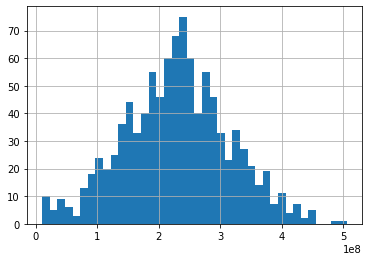

In [29]:
df_samples_sum.hist(bins=40)

In [30]:
df_samples_sum.describe( percentiles=[0.05,.25, .5, .75,0.95])

count    1.000000e+03
mean     2.289985e+08
std      8.603273e+07
min      1.015609e+07
5%       8.860131e+07
25%      1.723044e+08
50%      2.302793e+08
75%      2.841217e+08
95%      3.728187e+08
max      5.058033e+08
dtype: float64

## Left-hand panel LUISA part (run code below plot first)

### LUISA

In [39]:
df_inf_N0_agg.rename(mapper=sum_labels, inplace=True, axis=1)
df10 = df_inf_N0_agg
#df11 = df10.loc[df10.index==super_region]
df11 = pd.DataFrame(df10.sum(axis=0))
df11 = df11.T
df11

,Road and rail \n networks and \n associated land,Urban fabric,Industrial or \n commercial \n units,Other
0,1.477832e+08,5.040596e+07,6.960133e+07,3.928506e+07


In [40]:
#Total damage according to the grid-based method (LISFLOOD + LUISA)
df11.sum(axis=1)

0    3.070756e+08
dtype: float64

### CORINE

In [41]:
df_inf2_N0_agg.rename(mapper=sum_labels, inplace=True, axis=1)
df20 = df_inf2_N0_agg.copy()
df21 = pd.DataFrame(df20.sum(axis=0))
df21 = df21.T
df21

,Road and rail \n networks and \n associated land,Urban fabric,Industrial or \n commercial \n units,Water,Other
0,1.471716e+07,8.719265e+07,5.797679e+07,3.438308e+08,2.810704e+07


In [42]:
#Merge the CORINE and LUISA results
#df200
df200 = df21.append(df11,sort=False)
df200.index = ['(1) CORINE','(2) LUISA']
df200

,Road and rail \n networks and \n associated land,Urban fabric,Industrial or \n commercial \n units,Water,Other
(1) CORINE,1.471716e+07,8.719265e+07,5.797679e+07,3.438308e+08,2.810704e+07
(2) LUISA,1.477832e+08,5.040596e+07,6.960133e+07,NaN,3.928506e+07


## Visualisation break-down of total damage (right-hand panel)

In [60]:
#Investigate the composition of the high-flow graph; Curve 4 and 6
#df5 = df2[['EAD_C4','EAD_C6']].applymap(lambda x : pick_tuple(x,2))

#bar = pd.DataFrame(df5.sum(axis=1))
bar = pd.DataFrame(litmix_avg)
bar.columns = ['(4) Best estimate']
order = ['motorway','trunk','primary','secondary','tertiary','other','track']
bar = bar.groupby('road_type').sum()
bar = bar.T
bar = bar.reindex(columns=['motorway','trunk','primary','secondary','tertiary','other']) 
    # 'track' and 'none' are automatically removed from the data if they are not reindexed!
bar = bar*10**(-6)

bar = bar[bar.columns[::-1]] #reverse the order of the columns
bar

road_type,other,tertiary,secondary,primary,trunk,motorway
(4) Best estimate,53.957045,16.44029,34.19692,50.468935,16.748177,58.813303


In [61]:
#Calculate percentages
bar2 = bar.copy()
bar2 = 100*bar2/bar2.sum(axis=1).values[0]
bar2

road_type,other,tertiary,secondary,primary,trunk,motorway
(4) Best estimate,23.396042,7.128591,14.827954,21.88358,7.262093,25.50174


In [44]:
#Colormap OSM #made from a screenshot of osm.org and then use a colorpicker
OSM_colors = [
    '#E892A2', #Motorway
    '#F8B19B', #Trunk
    '#FBD5A6', #Primary
    '#F7FAC2', #Secondary
    '#FEFEFE', #Tertiary
    '#C4C4C4', #Made-up myself
]

brew_1 =  ['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']
brew_1

['#ffffb2', '#fed976', '#feb24c', '#fd8d3c', '#f03b20', '#bd0026']

In [54]:
#(df_samples.T.sum(axis=1)*10**(-6)).to_frame().tail(n=50)

## Plot the figure

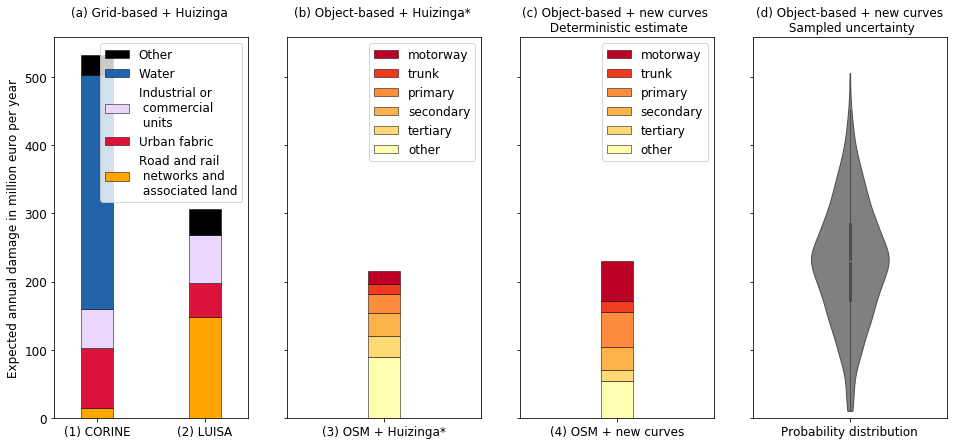

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 7), sharey=True)
fs = 12 #fontsize


### PANEL A
(df200*10**(-6)).plot.bar(stacked=True, ax=axes[0], color = pal2, width=0.3, linewidth=0.5,edgecolor='black', fontsize=fs)
axes[0].set_title('(a) Grid-based + Huizinga \n', fontsize=fs)
axes[0].set_ylabel('Expected annual damage in million euro per year', fontsize=fs)

handles_0, labels_0 = axes[0].get_legend_handles_labels() #inverse the order of the labels
axes[0].legend(handles_0[::-1], labels_0[::-1], fontsize=fs)

for tick in axes[0].get_xticklabels():
    tick.set_rotation(0)

### PANEL B
(df_HZ*10**(-6)).plot.bar(stacked=True, ax=axes[1],color=brew_1, width=0.1,linewidth=0.5,edgecolor='black')
axes[1].set_title('(b) Object-based + Huizinga* \n', fontsize=fs)
axes[1].set_xticklabels(['(3) OSM + Huizinga*'], fontsize=fs)
handles_2, labels_2 = axes[1].get_legend_handles_labels() #inverse the order of the labels
axes[1].legend(handles_2[::-1], labels_2[::-1], fontsize=fs)

for tick in axes[1].get_xticklabels(): #rotate the axis label
    tick.set_rotation(0)

### PANEL C
bar.plot.bar(stacked=True, ax=axes[2], color=brew_1, width=0.1,linewidth=0.5,edgecolor='black')
axes[2].set_title('(c) Object-based + new curves \n Deterministic estimate', fontsize=fs)

handles_2, labels_2 = axes[2].get_legend_handles_labels() #inverse the order of the labels
axes[2].legend(handles_2[::-1], labels_2[::-1], fontsize=fs)
axes[2].set_xticklabels(['(4) OSM + new curves'], fontsize=fs) #overrule the name of the index


for tick in axes[2].get_xticklabels():
    tick.set_rotation(0)
    
### PANEL D   
sns.violinplot(df_samples.T.sum(axis=1)*10**(-6),orient='v',ax=axes[3],width=0.4,linewidth=1,cut=0,color='grey')    
axes[3].set_title('(d) Object-based + new curves\n Sampled uncertainty', fontsize=fs)
axes[3].set_xticklabels(['Probability distribution'], fontsize=fs)
axes[3].set_ylim(bottom=0)


plt.savefig(r"Paper_fig5_gitversion_rev2.png", dpi=400, bbox_inches="tight")

In [50]:
df_samples.sum(axis=0).describe(percentiles=(0.05,0.25,0.75,0.95))

count    1.000000e+03
mean     2.289985e+08
std      8.603273e+07
min      1.015609e+07
5%       8.860131e+07
25%      1.723044e+08
50%      2.302793e+08
75%      2.841217e+08
95%      3.728187e+08
max      5.058033e+08
dtype: float64

In [47]:
df_samples.sum(axis=0).median()

230279277.6035468

In [48]:
df_samples.sum(axis=0).mean()

228998537.8338692

### Load data from LUISA

In [34]:
### Load the NUTS-3 EADS from all the LUISA pickles; these were created with LUISA_EAD_multi.ipynb
main_folder = "D:\\Europe_trade_disruptions"
LUISA_pickles_path = os.path.join(main_folder,"JRC_damages\\LUISA_pickles")
LUISA_infra_pkls = [x for x in os.listdir(LUISA_pickles_path) if x.endswith("infra.pkl")]
LUISA_infra_df = pd.DataFrame()
for pkl in tqdm(LUISA_infra_pkls):
    LUISA_infra_df = LUISA_infra_df.append(pd.read_pickle(os.path.join(LUISA_pickles_path,pkl)))
df_inf = LUISA_infra_df.copy()
df_inf.index.name = 'NUTS-3'

#ADD THE OVERARCHING NUTS-NAMES
df_inf['NUTS-2'] = df_inf.index.map(lambda x: NUTS_down(x))
df_inf['NUTS-0'] = df_inf.index.map(lambda x: NUTS_down(NUTS_down(NUTS_down(x))))
df_inf['sum'] = df_inf.sum(axis=1, numeric_only=True)


100%|█████████████████████████████████████████████████████████████████████████████| 1433/1433 [00:14<00:00, 101.16it/s]


In [35]:
df_inf_N0 = df_inf.groupby('NUTS-0').sum().drop(['sum'],axis=1)
df_inf_N0 = df_inf_N0.loc[:, (df_inf_N0 != 0).any(axis=0)] #drop the empty columns before plotting
df_inf_N0.head()

,1111,1121,1122,1123,1211,1212,1213,1221,1222,1230,1241,1242,1410,1422,2110,2310,2420,3110,3210,3240,3310,4100,5110,5120,5230
NUTS-0,,,,,,,,,,,,,,,,,,,,,,,,,
AL,2956.700000,1.157493e+04,35412.360000,18956.310000,2.148347e+04,187.420000,0.000000,1.792274e+05,0.000000,3002.110000,54461.96,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT,217185.118070,9.395351e+05,887348.493309,210877.662085,1.260108e+06,436739.222687,109354.957604,7.086000e+06,243.346203,551643.732922,443262.49,2187.00,159388.850061,85663.075177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BE,60982.796302,3.511544e+05,398394.703702,135177.084135,1.447278e+06,174489.310000,98179.904818,1.871703e+06,0.000000,469632.619626,27960.69,0.00,41610.740000,40555.850000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BG,5158.030000,6.069548e+04,81046.440000,39748.810000,3.458357e+05,4948.520000,10782.790000,8.381795e+05,0.000000,24706.140000,37842.71,146.67,12553.930000,5009.350000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CH,216548.320000,1.064747e+06,992132.700000,343352.270000,1.950108e+06,515248.460000,107504.290000,6.516137e+06,4093.600000,3790.810000,1965458.22,0.00,40798.750000,136134.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load the CORINE results

In [36]:
CORINE_pickles_path = "../../OSdaMage_10_old/corine_temp"
CORINE_infra_pkls = [x for x in os.listdir(CORINE_pickles_path) if x.endswith("infra.pkl")]
CORINE_infra_df = pd.DataFrame()
for pkl in tqdm(CORINE_infra_pkls):
    CORINE_infra_df = CORINE_infra_df.append(pd.read_pickle(os.path.join(CORINE_pickles_path,pkl)))
df_inf2 = CORINE_infra_df.copy()
df_inf2.index.name = 'NUTS-3'

#ADD THE OVERARCHING NUTS-NAMES
df_inf2['NUTS-2'] = df_inf2.index.map(lambda x: NUTS_down(x))
df_inf2['NUTS-0'] = df_inf2.index.map(lambda x: NUTS_down(NUTS_down(NUTS_down(x))))
df_inf2.drop(labels='RO225',axis='index',inplace=True) #something weird happens in this region
df_inf2['sum'] = df_inf2.sum(axis=1, numeric_only=True)
df_inf2_N0 = df_inf2.groupby('NUTS-0').sum().drop(['sum'],axis=1)
df_inf2_N0 = df_inf2_N0.loc[:, (df_inf2_N0 != 0).any(axis=0)] #drop the empty columns before plotting
df_inf2_N0.head()

100%|█████████████████████████████████████████████████████████████████████████████| 1420/1420 [00:07<00:00, 183.19it/s]


,1,2,3,4,5,6,10,12,18,20,21,23,24,26,28,29,30,32,35,37,38,40,42,43,44
NUTS-0,,,,,,,,,,,,,,,,,,,,,,,,,
AL,992.980000,1.216150e+05,1.954853e+04,311.040000,3002.110000,52727.76,0.000000,55728.56,648.76,39185.28,2097.22,1264.81,2821.66,75.76,531.2,16761.26,5271.09,1525.05,2101.45,3215.85,1718.68,7.353571e+05,7053.28,800.790000,679.42
AT,146347.828166,4.860787e+06,1.634625e+06,457939.323172,73408.667898,391538.90,46106.725417,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,9.247536e+06,0.00,0.000000,0.00
BE,75781.350000,2.032164e+06,1.388871e+06,532789.010000,289440.539897,8296.88,1772.770000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,8.166709e+05,0.00,940371.784686,0.00
BG,0.000000,3.858209e+05,3.520332e+05,101394.730000,46490.010000,23447.94,15360.180000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,5.559103e+06,0.00,0.000000,0.00
CH,112888.250000,4.398947e+06,2.192243e+06,501571.270000,138293.110000,1363745.28,33434.920000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,4.365148e+06,0.00,0.000000,0.00


In [37]:
#ADD THE LABELING FOR LUISA

from collections import OrderedDict

sum_dict = OrderedDict({
            1221:[1221],
            11:[1111,1121,1122,1123],
            121:[1211,1212,1213]
            })

#select columns that have not been grouped 
used_cols = []
for i in sum_dict:
    used_cols.extend(sum_dict[i])
sum_dict[0] = [j for j in list(df_inf_N0.columns) if j not in used_cols]

#sum_labels = OrderedDict({
#            1221: 'Road and rail networks and \n associated land (LUISA 1221)',
#            11: 'Urban fabric (LUISA 11XX)',
#            121: 'Industrial or commercial \n units (LUISA 121X)',
#            0: 'Other'})

sum_labels = OrderedDict({
            1221: 'Road and rail \n networks and \n associated land',
            11: 'Urban fabric',
            121: 'Industrial or \n commercial \n units',
            5: 'Water',
            0: 'Other'})

colours = OrderedDict({
            1221: '#FFA500',
            11: '#DC143C',
            121: '#EBD6FD',
            0: '#000000'})
pal = list(colours.values()) #create palette from colours

df_inf_N0_agg = pd.DataFrame()
for k, v in sum_dict.items():
    df_inf_N0_agg[k] = df_inf_N0[v].sum(axis=1)

In [38]:
#ADD THE LABELING FOR CORINE
#based on: D:\Europe_trade_disruptions\JRC_landuse\Corine_2012_g100_clc12_V18_5a\Legend\clc_legend.xls

sum_dict2 = OrderedDict({
            1221:[4], #comp code 4 corresponds to CLC3 122 ##was 122!
            11:[1,2], # 111,112
            121:[3], # 121
            5:[40,43,44] #511, 522, 523 
            })

used_cols2 = []
for i in sum_dict2:
    used_cols2.extend(sum_dict2[i])
sum_dict2[0] = [j for j in list(df_inf2_N0.columns) if j not in used_cols2]

colours2 = OrderedDict({
            1221: '#FFA500',
            11: '#DC143C',
            121: '#EBD6FD',
            5: '#2264aa', 
            0: '#000000'})
pal2 = list(colours2.values()) #create palette from colours

df_inf2_N0_agg = pd.DataFrame()
for k, v in sum_dict2.items():
    df_inf2_N0_agg[k] = df_inf2_N0[v].sum(axis=1)